In [1]:
## Import Packages 

import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

# Import Files
df = pd.read_excel("table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls")

In [2]:
## View Raw File
#pd.read_excel("table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls")
#df.dtypes

In [3]:
### Clean Data

## Create DataFrame Columns

df.columns = ['city', 'population','violent_crime', 
                    'murder', 'rape_revised','rape_legacy', 
                    'robbery', 'aggravated_assault', 'property_crime', 
                    'burglary', 'larceny_theft', 'vehicle_theft', 'arson']

## Drop extraneous rows and columns

df = df.drop(df.index[:4])
df = df.drop(df.index[-3:])
df = df.drop('rape_revised', axis=1 )

## Change Data Types of Columns

df.loc[:,'city'] = df.loc[:,'city'].apply(str)
df = df.apply(pd.to_numeric, errors='ignore')

## Replace outliers with 95th percentile

up_quantiles = df.quantile(0.95)
outliers_high = (df > df.quantile(0.95))
df[outliers_high] = np.nan
df.fillna(up_quantiles, inplace=True)

## Reset index

df.reset_index(inplace=True)
df.drop("index",axis=1,inplace=True)

In [4]:
## View Cleaned Data
df.head(10)
#df.dtypes
#df.describe()

,city,population,violent_crime,murder,rape_legacy,robbery,aggravated_assault,property_crime,burglary,larceny_theft,vehicle_theft,arson
0,Adams Village,1861.000,0.000,0.000,0.000,0.000,0.000,12.000,2.000,10.000,0.000,0.000
1,Addison Town and Village,2577.000,3.000,0.000,0.000,0.000,3.000,24.000,3.000,20.000,1.000,0.000
2,Akron Village,2846.000,3.000,0.000,0.000,0.000,3.000,16.000,1.000,15.000,0.000,0.000
3,Albany,56732.650,155.900,1.650,10.300,56.850,88.300,1377.700,222.250,1178.500,50.300,4.700
4,Albion Village,6388.000,23.000,0.000,3.000,4.000,16.000,223.000,53.000,165.000,5.000,4.700
5,Alfred Village,4089.000,5.000,0.000,0.000,3.000,2.000,46.000,10.000,36.000,0.000,4.700
6,Allegany Village,1781.000,3.000,0.000,0.000,0.000,3.000,10.000,0.000,10.000,0.000,0.000
7,Amherst Town,56732.650,107.000,1.000,7.000,31.000,68.000,1377.700,204.000,1178.500,32.000,3.000
8,Amityville Village,9519.000,9.000,0.000,2.000,4.000,3.000,210.000,16.000,188.000,6.000,1.000
9,Amsterdam,18182.000,30.000,0.000,0.000,12.000,18.000,405.000,99.000,291.000,15.000,0.000


# Multivariable Regression Analysis of FBI Data #

FBI crime data was used to create a model predicting property crimes.

## Analyzing the Data

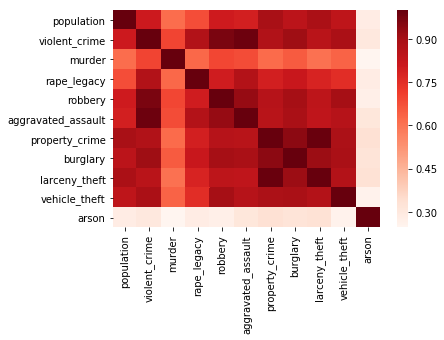

In [5]:
## Checking the Correlatedness of feature variables

sns.heatmap(df.corr(), cmap='Reds')
plt.show()

## Preparing the Data for Regression

### Principle Components Analysis

In [6]:
## Take Data For PCA

df_pca = df.loc[:, ['population', 'violent_crime', 'murder', 'rape_legacy',
       'robbery', 'aggravated_assault', 'burglary',
      'larceny_theft', 'vehicle_theft', 'arson'
           ]].dropna()

## Normalize the data 

X = StandardScaler().fit_transform(df_pca)

In [7]:
## Perform PCA

sklearn_pca = PCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(X)

In [8]:
## Evaluate PCA

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.76538122 0.08902699]


In [9]:
## Turn PCA Result into Dataframe

pca_df = pd.DataFrame(data=Y_sklearn
             , columns = ['component_1', 'component_2'])

In [10]:
## pca_df

In [11]:
## Store DataFrame For Regression

df_for_regression = pd.concat([pca_df, df['property_crime']], axis = 1)

In [12]:
df_for_regression.head(15)

,component_1,component_2,property_crime
0,-1.928,0.908,12.000
1,-1.797,0.928,24.000
2,-1.835,0.920,16.000
3,9.742,0.334,1377.700
4,-0.058,-0.991,223.000
5,-1.380,-1.137,46.000
6,-1.869,0.918,10.000
7,6.885,0.594,1377.700
8,-0.818,0.593,210.000
9,0.527,1.240,405.000


## Creating the Regression Model

In [13]:
## Store features and targets for regression

x = df_for_regression[['component_1', 'component_2']]
y = df_for_regression['property_crime']

Coefficients: 
 [127.58167038  -0.68892023]

Intercept: 
 279.5132183908045

R-squared:
 0.8905999243314461


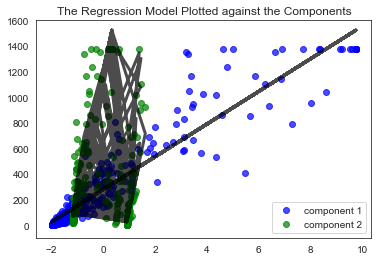

In [20]:
# Instantiate our model.
regr = linear_model.LinearRegression()

# Fit our model to our data.
regr.fit(x, y)

# Display the attributes we calculated.
print('Coefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:\n', regr.score(x, y))

# Plot outputs
sns.set_style("white")

plt.scatter(pca_df['component_1'], y, color='blue', alpha=.7, label = 'component 1')
plt.scatter(pca_df['component_2'], y, color='green', alpha=.7, label = 'component 2')
plt.plot(x, regr.predict(x), color='black', linewidth=3, alpha=.7)
plt.title('The Regression Model Plotted against the Components')
plt.legend()
plt.show()

## Reflecting on the Modeling Process

I originally planned to use features engineered in the last assignment for the model. However, after seeing that almost all of the variables were highly correlated, I opted to perform a principal component analysis on all of the original variables and use the resulting components for the model. I chose to use only the 2 most useful features since together they already accounted for 85% of the variance in the variables.